# Import packages and data

In [ ]:
%%capture
!pip install bertopic umap hdbscan transformers anthropic openai tiktoken accelerate bitsandbytes adjustText peft==0.6.0

In [ ]:
# Import packages
import pandas as pd
import matplotlib
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import time
from tqdm import tqdm
from adjustText import adjust_text
from scipy.stats import ttest_ind, sem
from scipy import stats
from utils_bertopic import (
    show_text_length, 
    batch_token_count, 
    create_prompt, 
    generate_target_audience_twllama,
    generate_target_audience,
    str_to_list,
    similarity_check,
    assign_pork,
    pork_version,
    merge_and_classify,
    plot_pork_policy_ratios,
    plot_change,
    perform_t_test,
    plot_change_each,
    visualization,
    translation
)

# Bertopic
import tensorflow as tf
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from transformers.pipelines import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.backend import OpenAIBackend
from bertopic.representation import TextGeneration
from bertopic.representation import ZeroShotClassification
from bertopic.representation import KeyBERTInspired
from bertopic.representation import OpenAI

# OpenAI
import openai

# Gemini
from google.colab import userdata
import google.generativeai as genai

# Taiwan LLAMA
from torch import bfloat16
from transformers import BitsAndBytesConfig
import transformers
import accelerate
import bitsandbytes as bnb
from peft import PeftModel

# Claude 2
import anthropic

# Huggingface
import torch
from transformers import pipeline

## Assess to Google Drive

In [ ]:
from google.colab import drive
from google.colab import userdata
import numpy as np
from numpy import random
import os
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')
HUGGINGFACE_API_KEY = userdata.get('HUGGINGFACE_API_KEY')

# Set seed for reproduction
SEED = random.randint(100)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup work directory
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Dissertation')
os.listdir() # overview the files

Mounted at /content/drive


['stopwords_zh-tw.txt',
 'Manifestos_RawData',
 'Final_Data',
 'Graph',
 '碩士論文研究計畫書.docx',
 'NMF_Result',
 'topic_info.gsheet',
 'topic_info.csv',
 'Manifesto_Dataset_Origin.csv',
 'Manifesto_Dataset.csv',
 'Embedding_OPENAI_SENTENCE.csv',
 'Result']

In [ ]:
years = [1992, 1995, 1998, 2001, 2004, 2008, 2012, 2016, 2020, 2024]
df = pd.read_csv('Manifesto_Dataset.csv')

In [ ]:
df = df[df['SENTENCE'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40471 entries, 0 to 40556
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 40471 non-null  object 
 1   LNAME              40471 non-null  object 
 2   TH                 40471 non-null  int64  
 3   AREA               40471 non-null  object 
 4   PARTY              40471 non-null  object 
 5   PARTY_CODE         40471 non-null  int64  
 6   GENDER             40471 non-null  int64  
 7   INCUMBENT          40471 non-null  int64  
 8   EDUCATION          40471 non-null  object 
 9   ELE                40471 non-null  int64  
 10  VOTES              40471 non-null  int64  
 11  VOTER_TURNOUT      40471 non-null  float64
 12  CONTENT            40471 non-null  object 
 13  ENOUGH_VOTE        40471 non-null  bool   
 14  MAIN_PARTY_MEMBER  40471 non-null  bool   
 15  SERIOUS_CANDIDATE  40471 non-null  int64  
 16  SENTENCE           404

In [ ]:
df.groupby('TH').size()

TH
2     4070
3     3630
4     4350
5     4590
6     3920
7     3714
8     2860
9     3960
10    5520
11    3857
dtype: int64

# Preprocess Manifesto Data

In [ ]:
df['SENTENCE'] = df['SENTENCE'].astype(str)
df['CLEAN_CONTENT'] = df['CLEAN_CONTENT'].astype(str)

In [ ]:
# ALL Manifestos
df['CONTENT_LENGTH'] = df.groupby('ID')['CONTENT'].transform(lambda x: x.apply(len))
print(f'There are {len(df)} documents in total.') # 40471

There are 40471 documents in total.


In [ ]:
# Serious candidates
print(f"There are {len(df[df['SERIOUS_CANDIDATE'] == 1])} policies that are raised by serious candidates.") # 34544 / 40471

There are 34544 policies that are raised by serious candidates.


## Document length count
Firstly, show the distribution of the original manifesto length.  
Secondly, as I segment manifestos by policies, the 2nd figure shows the distribution of it.

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
# 計算 TOKEN 欄位中的每個詞彙數（長度）
def show_text_length(column, save=False):
  plt.figure(figsize=(10, 6))
  sns.histplot(column, bins=30, alpha=0.7, color='grey', edgecolor="black", linewidth=0.5)
#   plt.title('Distribution of Content Length of Taiwan Manifesto')
  plt.xlabel('Text Length of Manifestos')
  plt.ylabel('Frequency')
  if save:
      plt.savefig(('Graph/Distribution_token_length'))
  else:
      plt.show()

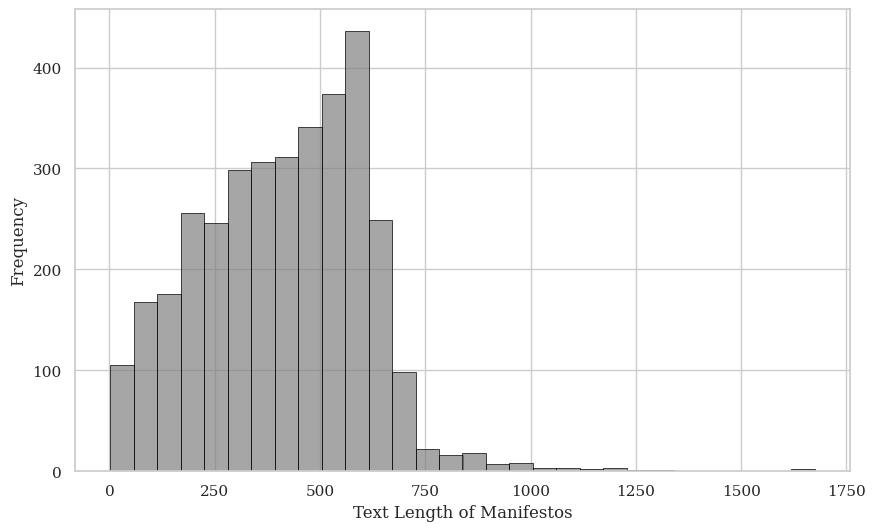

In [ ]:
text_length = df.groupby('ID')['CONTENT_LENGTH'].sum().reset_index()
show_text_length(text_length['CONTENT_LENGTH'], save=True)

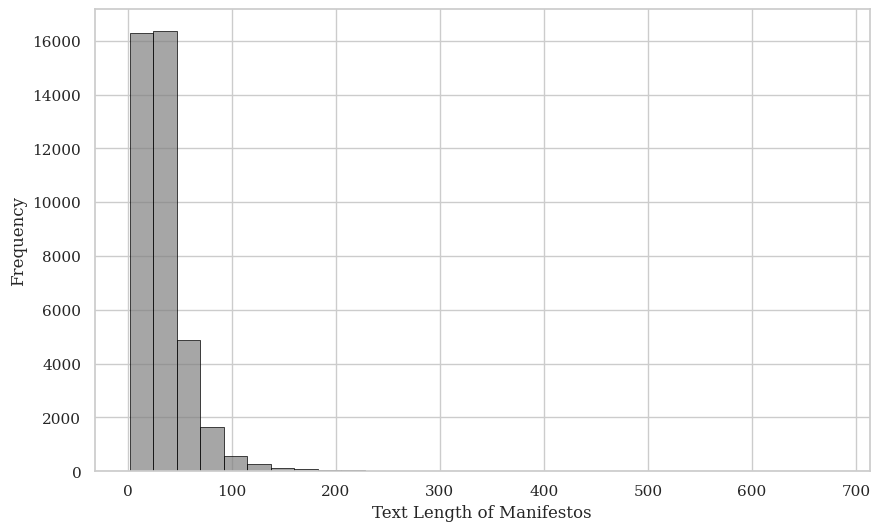

In [ ]:
show_text_length(df['CONTENT_LENGTH'], save=False)

## Set Batch Size

In [ ]:
input_length = batch_token_count(df, 'cl100k_base', 99) # The max input length is 8191

print(f'How many batchs have more tokens than 8191: {sum(np.array(input_length) > 8191)}')
print(sum(input_length))

How many batchs have more tokens than 8191: 0
1744154


# BERTopic model

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Embedding Model

In [ ]:
from transformers.pipelines import pipeline

embedding_model = pipeline("feature-extraction", model="hfl/chinese-roberta-wwm-ext", device=device)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Dimension Reduction

In [ ]:
# Dimension reduction
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric='cosine', random_state=SEED)

## Clustering

In [ ]:
# Clustering
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Vectorize

In [ ]:
vectorizer_model = CountVectorizer(max_df=0.99, min_df=0.005)

## Representation Model

In [ ]:
# Representation model fine-tuning using gpt-3.5-turbo
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format and use only traditional Chinese:
topic: <topic label>
"""

summarization_prompt = """
I have a topic that is described by the following keywords: [KEYWORDS]
In this topic, the following documents are a small but representative subset of all documents in the topic:
[DOCUMENTS]

Based on the information above, please give a description of this topic in the following format and use only traditional Chinese with no more than 15 words:
topic: <description>
"""

client = openai.OpenAI(api_key=OPENAI_API_KEY)
gpt_turbo= OpenAI(client, model="gpt-4-turbo-preview", delay_in_seconds=4, chat=True, prompt=summarization_prompt, generator_kwargs={'top_p':0.9, 'temperature': 1})

In [ ]:
# Create zeroshot classification model
candidate_topics = ["地方服務", "地方藝文休閒觀光", "地方基礎建設", "地方建設", "地方族群",
                    "地方警政治安", "地方區域整合", "政黨政治", "憲政議題", "國會改革", "外交國防",
                    "經濟", "財政", "教育文化", "交通", "法制司法", "社會福利", "消費者保護",
                    "醫療衛生", "環境", "其他"]
zeroshot_representation = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

# Create KeyBERT model
keybert = KeyBERTInspired(top_n_words=15)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
representation_model = {
    "GPT": gpt_turbo,
}

## Claude

## OPENAI

### Emedding

In [ ]:
# Corpus
documents = df["SENTENCE"].tolist()
batch_size = 99
all_embeddings = []
client = openai.OpenAI(api_key=OPENAI_API_KEY)

for i in range(0, len(documents), batch_size):
    batch = documents[i:i+batch_size]
    response = client.embeddings.create(input=batch, model="text-embedding-3-large") # 使用第三代模型
    batch_embeddings = [r.embedding for r in response.data]
    all_embeddings.extend(batch_embeddings)

embeddings = np.array(all_embeddings)

In [ ]:
embedding_df = pd.DataFrame(embeddings)
embedding_df.to_csv('Embedding_OPENAI_SENTENCE.csv', index=False, header=None)

### Model

In [ ]:
# Embedding_OPENAI.csv is for column CLEAN_CONTENT
# Embedding_OPENAI_SENTENCE.csv is for column SENTENCE
embedding = pd.read_csv('Embedding_OPENAI_SENTENCE.csv', header=None)

In [ ]:
print(embedding.shape)
embeddings = embedding.to_numpy()

(40471, 3072)


In [ ]:
# Now pass the embeddings to BERTopic
topic_model = BERTopic(language="Chinese",
                       verbose=True,
                       calculate_probabilities=True,
                       umap_model=umap_model, # Dimention reduction
                       hdbscan_model=hdbscan_model, # Clustering
                       vectorizer_model=vectorizer_model, # Vectorize
                       # n_gram_range=(1)
                       )

documents = df["SENTENCE"].tolist() # SENTENCE 有斷詞處理
topics, probs = topic_model.fit_transform(documents, embeddings)

2024-03-20 15:27:44,900 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-20 15:28:39,753 - BERTopic - Dimensionality - Completed ✓
2024-03-20 15:28:39,757 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-20 15:30:07,713 - BERTopic - Cluster - Completed ✓
2024-03-20 15:30:07,731 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-20 15:30:12,461 - BERTopic - Representation - Completed ✓


# Post Processing

In [ ]:
# Overview topics
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,13080,-1_臺灣_政治_人民_經濟,"[臺灣, 政治, 人民, 經濟, 交通, 推動, 政府, 發展, 爭取, 國家]",[（四） 經濟 安全 改善 經濟 環境 積極 引進 國外 資金 人才 制定 環境 基本法 確...
1,0,2110,0_教育_教師_學校_教學,"[教育, 教師, 學校, 教學, 敎育, 大學, 學生, 學習, 高中, 升學]","[徹底 檢討 敎育 制度 文化 環境 保障 教師 學生 權益, 教育 文化, 推動 教育]"
2,1,1482,1_婦女_托育_幼兒_兩性,"[婦女, 托育, 幼兒, 兩性, 育兒, 生育, 平等, 補助, 女性, 平權]","[落實 婦女 政策 提升 婦女 福利 保障 婦女 權益, 推動 提高 婦女 就業 機會 保障..."
3,2,1250,2_弱勢_殘障_福利_團體,"[弱勢, 殘障, 福利, 團體, 照顧, 社會, 老人, 族群, 障礙, 兒童]","[爭取 老人 福利 照顧 弱勢 團體, 保障 弱勢 爭取 婦女 兒童 殘障 老人 更多 社會..."
4,3,1051,3_勞工_勞資_勞動_外勞,"[勞工, 勞資, 勞動, 外勞, 失業, 權益, 工資, 保障, 就業, 勞保]","[保障 勞工 權益, 保障 勞工 權益, 勞工]"
...,...,...,...,...,...
190,189,21,189_ｐｍ_當今_阻止_潮流,"[ｐｍ, 當今, 阻止, 潮流, 排放, 危害, 乃是, 公害, 空氣, 水土]","[當今 世界 潮流 家園 減少 排放 阻止 ＰＭ ２.５ 危害 臺灣 人民, 當今 世界 潮..."
191,190,21,190_救世島_昭昭_反之_世界,"[救世島, 昭昭, 反之, 世界, 下載, 天命, 圍堵, 對抗, 歡迎, 出路]",[不要 任何 政黨 國會 過半 圍堵 人民 出路 人民 機會 改變 歷史 永久 和平 臺灣 ...
192,191,21,191_住民_同等_陸配_外配,"[住民, 同等, 陸配, 外配, 原住民, 待遇, 歧視性, 國民, 納稅, 團體]","[照顧 住民 原住民 弱勢 團體 爭取 陸配 外配 同等 國民 權益, 照顧 住民 原住民 ..."
193,192,21,192_生物_夜市_加工區_科技,"[生物, 夜市, 加工區, 科技, 招商, 商機, 園區, 轉型為, 觀光, 活動]",[１０ 完成 生物 醫學 科技 園區 陽明 醫學 中心 提供 高品質 醫療 服務 創造 生物...


In [ ]:
topic_dict = {}
for i in range(topic_info.shape[0]-1):
    # 注意get_topic返回的是一個tuple列表，我們只需要每個tuple的第一個元素，即關鍵字本身
    keywords = topic_model.get_topic(i)
    words = []
    for word in keywords:
        words.append(word[0])
    topic_dict['Topic' + str(i)] = words

# 將字典轉換成DataFrame
topic_df = pd.DataFrame(topic_dict)
topic_df

In [ ]:
topic_model.visualize_barchart(top_n_topics=12)

In [ ]:
topic_model.visualize_documents(documents, hide_document_hover=True,
                                embeddings=embeddings, hide_annotations=True)

In [ ]:
topic_model.visualize_topics()

### Taiwan LLAMA

#### Generate data for fine-tuning Taiwan LLAMA

In [ ]:
import pandas as pd
import uuid

# We use 廖達琪's standatd of classification
audience_list = ["全民", "軍公教", "台商", "老人", "婦女", "原住民", "族群", "外籍人士",
                 "學生", "中壯年", "青少年", "兒童", "榮民", "勞工", "工商企業",
                 "公益團體(社福團體)", "專業人士", "特殊技能人士", "弱勢(含性工作者、更生人、卡奴、腳踏車騎士)",
                 "僑民", "殘障(身心障礙)", "失業", "低收入戶", "中間選民", "投資者", "父母家長親子", "單親家庭",
                 "選任公務人員", "農漁民", "網民", "地區居民", "市民"]

def check_only_local_residents(lst):
    return all(item.startswith('地區居民') for item in lst)


df = pd.read_csv('topic_info.csv')
df['PORK_GPT'] = df['Target_Audience_GPT'].apply(lambda x: 'PORK' if check_only_local_residents(x) else 'POLICY')
df['prompt_for_taiwan_llama'] = df.apply(create_prompt, axis=1)
new_df = df[['prompt_for_taiwan_llama', 'PORK_GPT']].copy()
new_df.rename(columns={'prompt_for_taiwan_llama': 'instruction', 'PORK_GPT': 'output'}, inplace=True)
num_rows = len(new_df)
uuids = [str(uuid.uuid4()) for _ in range(num_rows)]
new_df.insert(0, 'id', uuids)

In [ ]:
new_df.to_json('train.json', orient='records', force_ascii=True, lines=False)

## Fine-tuning Representation

In [ ]:
topic_model.update_topics(docs=documents, representation_model=representation_model)

100%|██████████| 125/125 [16:34<00:00,  7.96s/it]


In [ ]:
topic_info_gpt = topic_model.get_topic_info()
topic_info_gpt.head(5)

,Topic,Count,Name,Representation,GPT,Representative_Docs
0,-1,15462,-1_臺灣_政府_推動_經濟,"[臺灣, 政府, 推動, 經濟, 人民, 勞工, 爭取, 社會, 交通, 國家]",[政府推動經濟發展與社會安全，重視勞工權益與公共交通建設。],"[發展 經濟 臺灣, 建立 就業 安全 体系 督促 政府 規劃 失業 保險 政策 兼顧 經濟..."
1,0,2520,0_教育_教師_學校_學生,"[教育, 教師, 學校, 學生, 敎育, 教學, 學費, 文化, 學習, 大學]",[教育改革、提升教學品質、保障教師權益、學費調整、學生支援政策],"[改善 教育 制度 保障 教師 權益, 推動 教育, 教育 檢討 一貫 課程 提升 學生 基..."
2,1,1802,1_觀光_文化_園區_產業,"[觀光, 文化, 園區, 產業, 開發, 發展, 特色, 休閒, 地方, 藝術]",[透過政策與資源整合，促進觀光、文化藝術與地方產業發展，增添地方特色與休閒價值。],"[觀光 政策, 設置 國家 景點 發展 生態 觀光 爭取 雲林 設置 國家級 觀光 景點 帶..."
3,2,990,2_立委_問政_參選_民意,"[立委, 問政, 參選, 民意, 立法委員, 當選, 專業, 服務, 政見, 選舉]",[立法委員選舉，強調理性問政、民意服務及推動改革。],[立委 傾聽 民意 推動 立法 解決 問題 萬安會 秉持 理性 問政 創新 立法 理念 民眾...
4,3,875,3_治安_警察_犯罪_安全,"[治安, 警察, 犯罪, 安全, 打擊, 毒品, 警政, 員警, 社區, 警力]",[加強警力與法案以打擊犯罪，維護社會治安及民眾安全。],"[推動 警政 治安 法案 打擊 犯罪 確保 民眾 安全, 社會 治安 強化 警力 裝備 打擊..."


## Target Audience Generation

In [ ]:
# Hyperparameters
TOP_P = 0.95
TOP_K = 40
TEMPERATURE = 0.7
MAX_NEW_TOKENS = 500
REPETITION_PENALTY = 1.1

In [ ]:
topic_info = generate_target_audience(topic_info_gpt, 'Gemini')

Generating target audiences: 100%|██████████| 125/125 [17:19<00:00,  8.32s/it]


In [ ]:
topic_info = generate_target_audience(topic_info_gpt, 'Claude')

In [ ]:
topic_info = generate_target_audience(topic_info_gpt, 'GPT')

Generating target audiences: 100%|██████████| 125/125 [10:39<00:00,  5.12s/it]


In [ ]:
# Check the output of LLM models
topic_info['Target_Audience_Gemini'] = topic_info['Target_Audience_Gemini'].apply(str_to_list)
topic_info['Target_Audience_GPT'] = topic_info['Target_Audience_GPT'].apply(str_to_list)
topic_info['Target_Audience_Claude'] = topic_info['Target_Audience_Claude'].apply(str_to_list)

In [ ]:
# We use 廖達琪's standatd of classification
audience_list = ["全民", "軍公教", "台商", "老人", "婦女", "原住民", "族群", "外籍人士",
                 "學生", "中壯年", "青少年", "兒童", "榮民", "勞工", "工商企業",
                 "公益團體(社福團體)", "專業人士", "特殊技能人士", "弱勢(含性工作者、更生人、卡奴、腳踏車騎士)",
                 "僑民", "殘障(身心障礙)", "失業", "低收入戶", "中間選民", "投資者", "父母家長親子", "單親家庭",
                 "選任公務人員", "農漁民", "網民", "地區居民", "市民"]

def check_only_local_residents(lst):
    filtered_lst = [item for item in lst if item.startswith('地區居民') or item in audience_list]
    return all(item.startswith('地區居民') for item in filtered_lst) if filtered_lst else False

topic_info['PORK_Gemini'] = topic_info['Target_Audience_Gemini'].apply(lambda x: 1 if check_only_local_residents(x) else 0)
topic_info['PORK_GPT'] = topic_info['Target_Audience_GPT'].apply(lambda x: 1 if check_only_local_residents(x) else 0)
topic_info['PORK_Claude'] = topic_info['Target_Audience_Claude'].apply(lambda x: 1 if check_only_local_residents(x) else 0)

In [ ]:
similarity_check(topic_info)

Similarity of GPT vs. Gemini: 0.896
Similarity of GPT vs. Claude: 0.864
Similarity of Claude vs. Gemini: 0.888
Similarity of three models: 0.824


(112, 108, 111, 103)

In [ ]:
topic_info = assign_pork(topic_info)

In [ ]:
topic_info.to_csv('Result/Result_v6/topic_info_v6.csv', encoding='utf-8-sig', index=False)

In [ ]:
topic_column_gpt = topic_model.get_document_info(df['SENTENCE'])
topic_column_gpt.head(3)

,Document,Topic,Name,Representation,GPT,Representative_Docs,Top_n_words,Probability,Representative_document
0,建請 政府 落實 農民 保險 提升 農民 生活 品質,14,14_農民_農業_漁民_農漁民,"[農民, 農業, 漁民, 農漁民, 價格, 產銷, 農產品, 漁業, 收購, 災害]",[保障農漁民生計，推動農業發展，建立產銷穩定，農產漁業災害保障。],[農業 推動 農業 保險 設立 農業 博物館 修正 農業 天然 災害 救助 辦法 保障 農民...,農民 - 農業 - 漁民 - 農漁民 - 價格 - 產銷 - 農產品 - 漁業 - 收購 - 災害,0.578161,False
1,建全 農產 運銷 制度 保障 農民 權益,14,14_農民_農業_漁民_農漁民,"[農民, 農業, 漁民, 農漁民, 價格, 產銷, 農產品, 漁業, 收購, 災害]",[保障農漁民生計，推動農業發展，建立產銷穩定，農產漁業災害保障。],[農業 推動 農業 保險 設立 農業 博物館 修正 農業 天然 災害 救助 辦法 保障 農民...,農民 - 農業 - 漁民 - 農漁民 - 價格 - 產銷 - 農產品 - 漁業 - 收購 - 災害,0.258343,False
2,全工 退休 失業 保險 制度 及早 實施 全民 保險,29,29_年金_國民_老人_津貼,"[年金, 國民, 老人, 津貼, 保險, 發放, 實施, 敬老, 制度, 普及性]",[推動和實施國民年金制度，普及老人保障與津貼發放。],"[實施 國民 年金 制度 確保 老人 福利 安全, 推動 國民 年金 制度, 推動 國民 年...",年金 - 國民 - 老人 - 津貼 - 保險 - 發放 - 實施 - 敬老 - 制度 - 普及性,0.387814,False


In [ ]:
topic_distr, _ = topic_model.approximate_distribution(documents)
topic_model.visualize_distribution(topic_distr[1], min_probability=0.015)

## Pork / Policy Classification

In [ ]:
# Load Data again after human intervention
df_new = pd.read_csv('Result/Result_v3/Result_v3.csv')
df_origin = pd.read_csv('Manifesto_Dataset_Origin.csv')
topic_info_list = ["v1", "v2", "v3"]
topic_df = []

In [ ]:
for version in topic_info_list:
    df, globals()[f"topic_{version}"] = pork_version(df, version)
    topic_df.append(globals()[f"topic_{version}"])

In [ ]:
df_merge = merge_and_classify(df_new, topic_info_list)

In [ ]:
df_merge = pd.merge(df_origin, df_merge, on='ID', how='outer')
df_merge.shape

(3453, 28)

In [ ]:
missing_values = df_merge['WEIGHT_PORK_v1'].isna()
print(df_merge.loc[missing_values[missing_values == True].index])
df_merge.fillna(0, inplace=True)
df_merge['LNAME'] = df_merge['LNAME'].astype(str)
df_merge['LNAME'] = df_merge['LNAME'].apply(lambda x: x.split('_')[0])

                                        ID  LNAME   TH     AREA PARTY  \
1332  4fa17858-d9e1-4bf9-ab58-698784334e03  謝啟大_5  5.0  高雄市第一選區    新黨   
3452                                   NaN    NaN  NaN      NaN   NaN   

      PARTY_CODE  GENDER  INCUMBENT EDUCATION  ELE  ...  WEIGHT_PORK_v2  \
1332         4.0     0.0        1.0        99  0.0  ...             NaN   
3452         NaN     NaN        NaN       NaN  NaN  ...             NaN   

      PART_PORK_v2 WEIGHT_PORK_v3 PART_PORK_v3 WEIGHT_PORK_v4  PART_PORK_v4  \
1332           NaN            NaN          NaN            NaN           NaN   
3452           NaN            NaN          NaN            NaN           NaN   

      WEIGHT_PORK_v5  PART_PORK_v5  WEIGHT_PORK_v6  PART_PORK_v6  
1332             NaN           NaN             NaN           NaN  
3452             NaN           NaN             NaN           NaN  

[2 rows x 28 columns]


In [ ]:
df_serious = df_merge[df_merge['SERIOUS_CANDIDATE'] == 1]
len(df_serious) # 2860

2860

In [ ]:
df_serious.groupby('TH').size()

TH
2.0     272
3.0     257
4.0     344
5.0     373
6.0     302
7.0     207
8.0     238
9.0     286
10.0    313
11.0    268
dtype: int64

# Result

## Visualization

### 視覺化選制變革影響

In [ ]:
plt.rcdefaults()

In [ ]:
weight_cols = ['WEIGHT_PORK_v1', 'WEIGHT_PORK_v2', 'WEIGHT_PORK_v3']
equal_divided_cols = ['PART_PORK_v1', 'PART_PORK_v2', 'PART_PORK_v3']

PORK: 26, TOTAL: 132
PORK: 23, TOTAL: 141
PORK: 24, TOTAL: 128


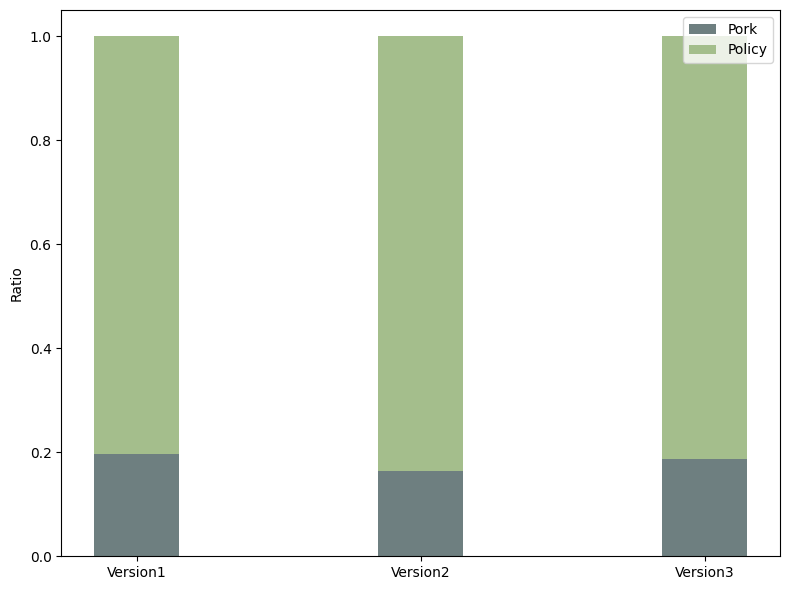

In [ ]:
plot_pork_policy_ratios(dfs=topic_df,
                        titles=['Version1', 'Version2', 'Version3'],
                        save=True)

In [ ]:
# 首先，選取TH欄位中為6或7的資料
filtered_df = df_merge[df_merge['TH'].isin([6, 7])]
candidates_in_both = filtered_df.groupby('LNAME').filter(lambda x: x['TH'].nunique() == 2)
candidates_in_both.groupby('TH').size()

TH
6.0    123
7.0    123
dtype: int64

mean: 0.11258463393653036, std: 0.16483899919977218
mean: 0.15126686210108678, std: 0.18654928326189638


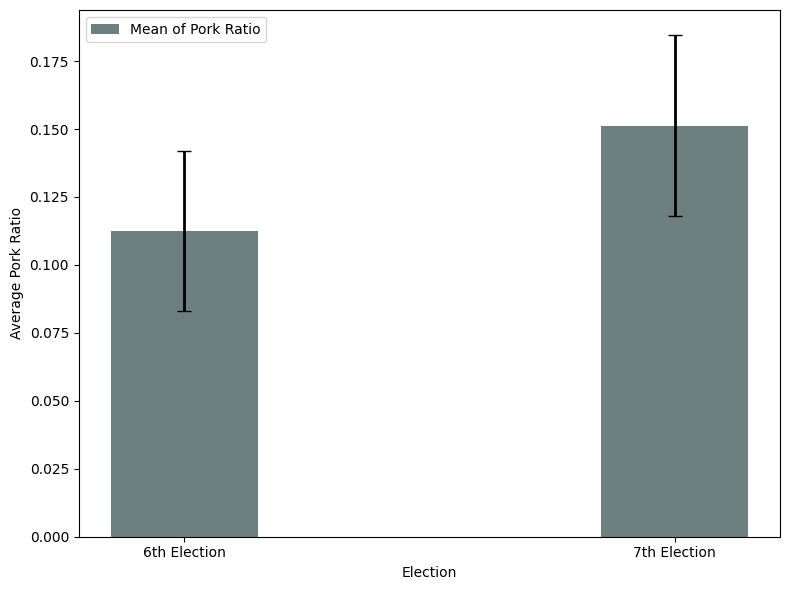

In [ ]:
plot_change(candidates_in_both, weight_cols, save=True)

In [ ]:
t_stat, p_value = perform_t_test(df=candidates_in_both,
                                 columns=weight_cols,
                                 candidate='連任候選人',
                                 save=False)

T-statistic: -2.9736183545325963, P-value: 0.0016192453552974302
連任候選人間存在顯著差異。


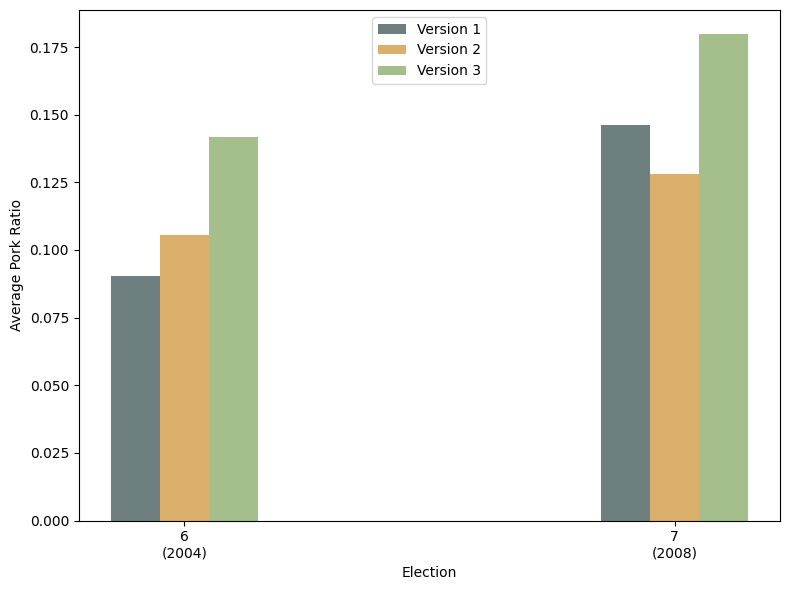

In [ ]:
plot_change_each(candidates_in_both, weight_cols, save=False)

### 視覺化趨勢

Number of candidates: 2860


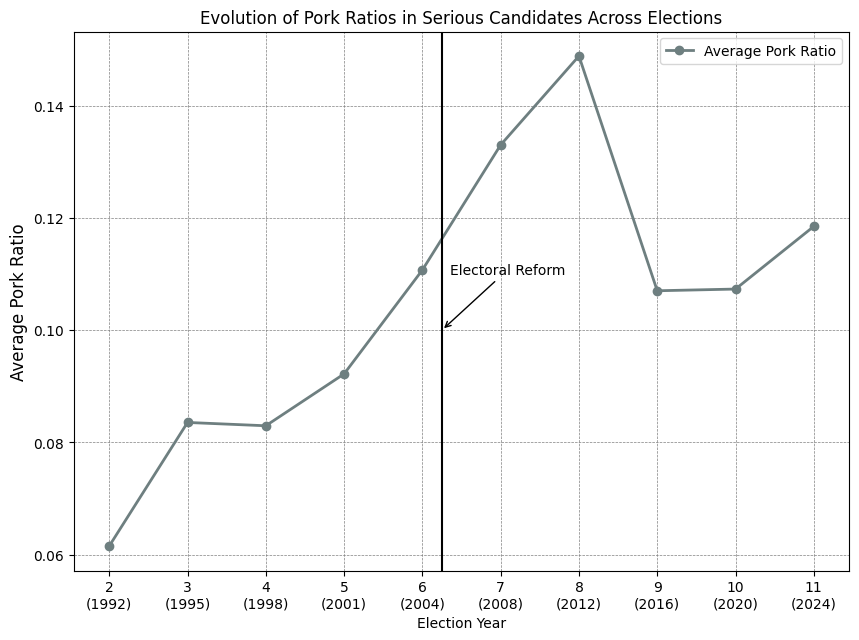

In [ ]:
%matplotlib inline
visualization(df=df_serious,
              model='BERTopic',
              y_axis=0.1,
              party='Serious',
              columns=weight_cols,
              reform_year=2005,
              save=True,
              avg=True) # 2860

In [ ]:
%matplotlib inline
visualization(df=df_serious,
              model='BERTopic',
              y_axis=0.07,
              party='Serious',
              columns=weight_cols,
              reform_year=2005,
              save=False) # 2860

In [ ]:
%matplotlib inline
visualization(df=df_serious,
              model='BERTopic',
              y_axis=0.07,
              party='All',
              columns=equal_divided_cols,
              reform_year=2005,
              save=False) # 2860

Number of candidates: 824


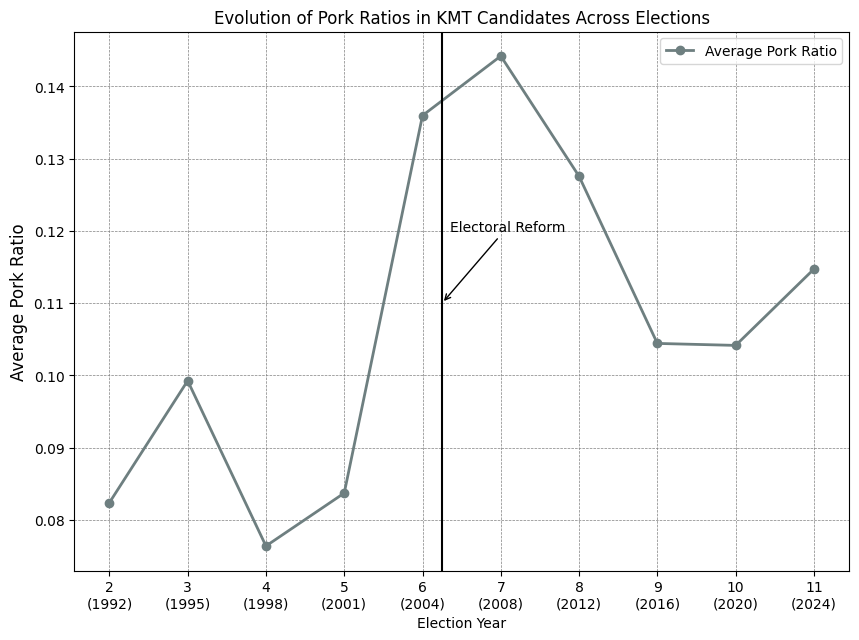

In [ ]:
%matplotlib inline
# KMT serious candidates' electoral strategy
visualization(df=df_serious[df_serious['PARTY_CODE'] == 1],
              model='BERTopic',
              y_axis=0.11,
              party='KMT',
              columns=weight_cols,
              reform_year=2005,
              save=True,
              avg=True) # 824

Number of candidates: 710


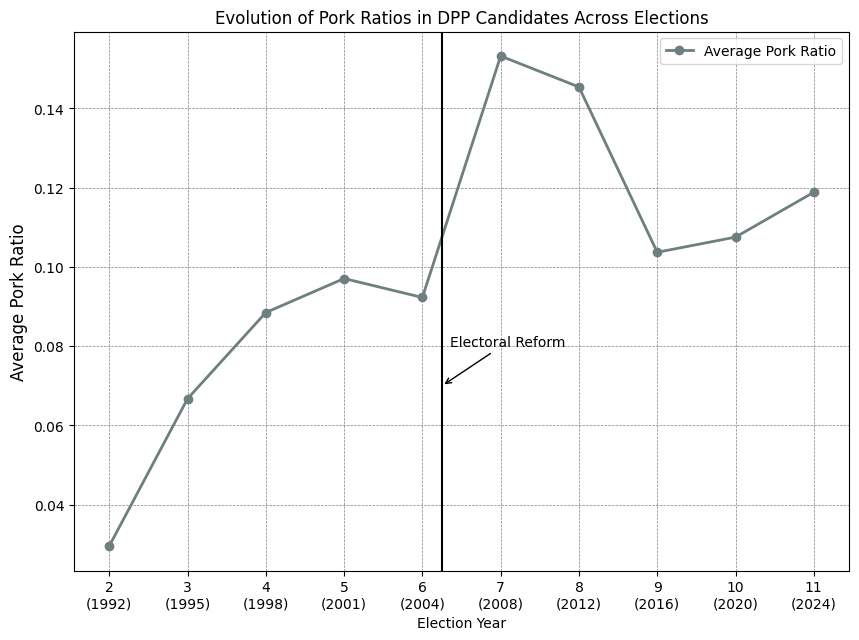

In [ ]:
%matplotlib inline
# DPP serious candidates' electoral strategy
visualization(df=df_serious[df_serious['PARTY_CODE'] == 2],
              model='BERTopic',
              y_axis=0.07,
              party='DPP',
              columns=weight_cols,
              reform_year=2005,
              save=True,
              avg=True) # 710

Number of candidates: 2036


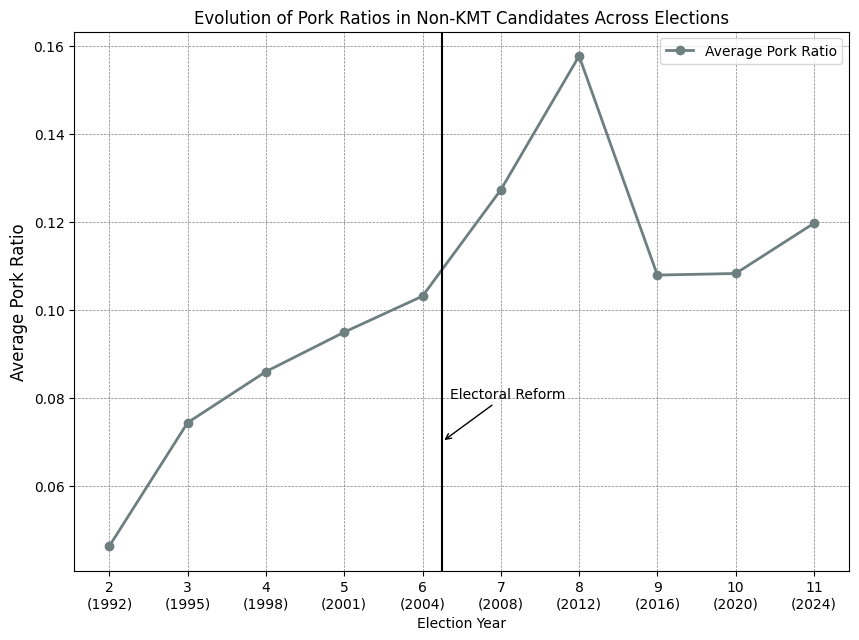

In [ ]:
%matplotlib inline
# Non KMT serious candidates' electoral strategy
visualization(df=df_serious[df_serious['PARTY_CODE'] != 1],
              model='BERTopic',
              y_axis=0.07,
              party='Non-KMT',
              columns=weight_cols,
              reform_year=2005,
              save=True,
              avg=True) # 2036

In [ ]:
%matplotlib inline
# Non KMT & DPP serious candidates' electoral strategy
visualization(df=df_serious.query('PARTY_CODE > 2'),
              model='BERTopic',
              y_axis=0.08,
              party='Non-KMT&DPP',
              columns=weight_cols,
              reform_year=2005,
              save=False,
              avg=False) # 1326

Number of candidates: 1326


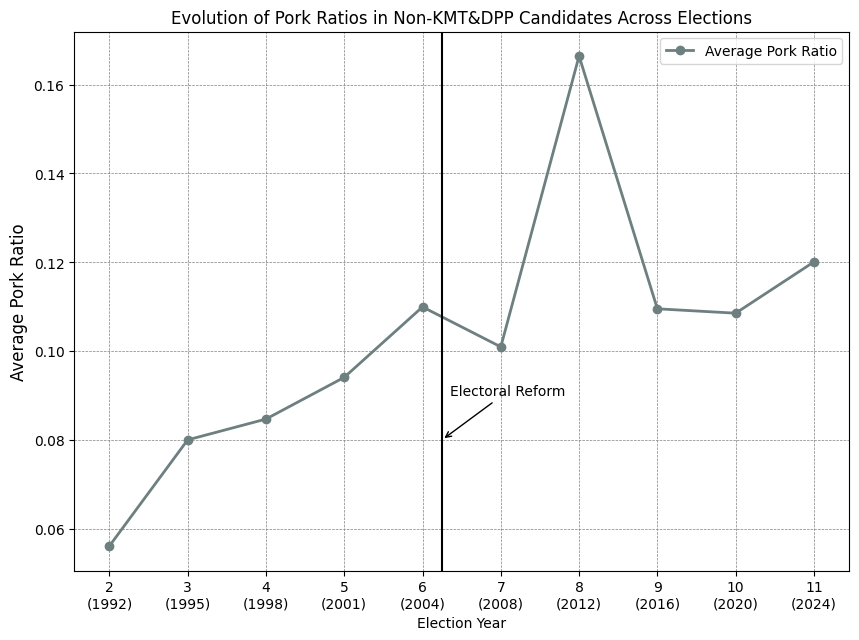

In [ ]:
%matplotlib inline
# Non KMT & DPP serious candidates' electoral strategy
visualization(df=df_serious.query('PARTY_CODE > 2'),
              model='BERTopic',
              y_axis=0.08,
              party='Non-KMT&DPP',
              columns=weight_cols,
              reform_year=2005,
              save=True,
              avg=True) # 1326

Number of candidates: 809


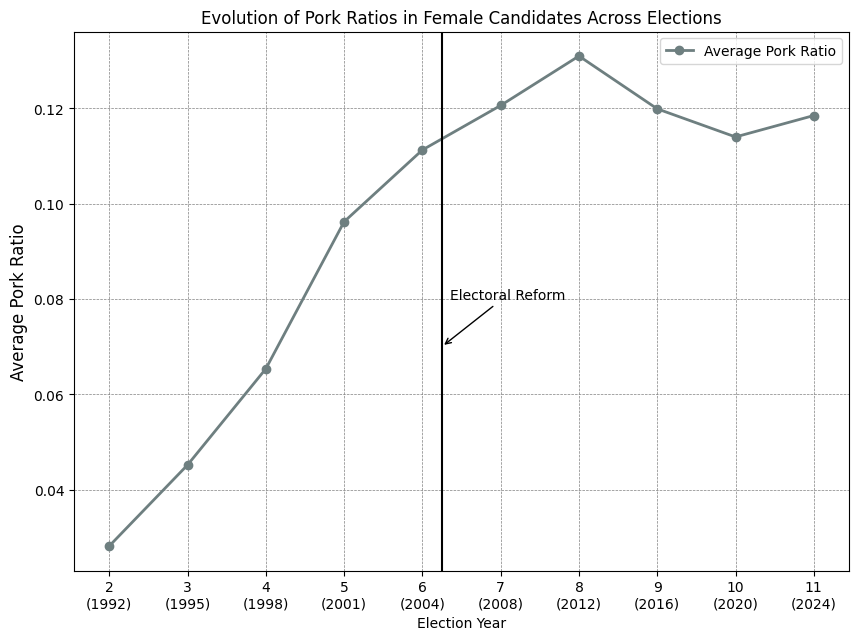

In [ ]:
%matplotlib inline
# Female serious candidates' electoral strategy
visualization(df=df_serious[df_serious['GENDER'] == 0],
              model='BERTopic',
              y_axis=0.07,
              party='Female',
              columns=weight_cols,
              reform_year=2005,
              save=True,
              avg=True) # 809

Number of candidates: 2860


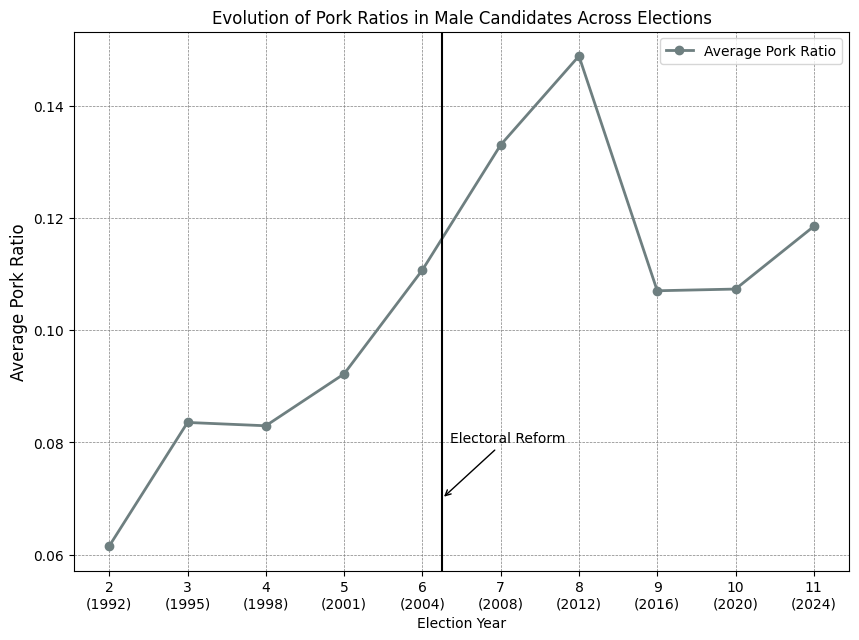

In [ ]:
%matplotlib inline
# Male serious candidates' electoral strategy
visualization(df=df_serious,
              model='BERTopic',
              y_axis=0.07,
              party='Male',
              columns=weight_cols,
              reform_year=2005,
              save=False,
              avg=True) # 2860

## Model Validation and Visualization

## T test

In [ ]:
t_stat, p_value = perform_t_test(df_serious, weight_cols, '認真型候選人')

T-statistic: -2.586010000673384, P-value: 0.010057228671460734
認真型候選人間存在顯著差異。


In [ ]:
t_stat, p_value = perform_t_test(df_serious[df_serious['PARTY_CODE'] == 1], weight_cols, '國民黨候選人')

print(f"國民黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] == 1])}")
print(f"第六屆國民黨提名人數: {len(df_serious.query('PARTY_CODE == 1 and TH < 7'))}")
print(f"第七屆國民黨提名人數: {len(df_serious.query('PARTY_CODE == 1 and TH >= 7'))}")

T-statistic: -0.503936910337207, P-value: 0.6151092902694137
國民黨候選人間不存在顯著差異。
國民黨提名人數: 824
第六屆國民黨提名人數: 477
第七屆國民黨提名人數: 347


In [ ]:
t_stat, p_value = perform_t_test(df_serious[df_serious['PARTY_CODE'] == 2], weight_cols, '民進黨候選人')

print(f"民進黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] == 2])}")
print(f"民進黨提名人數: {len(df_serious.query('PARTY_CODE == 2 and TH < 7'))}")
print(f"民進黨提名人數: {len(df_serious.query('PARTY_CODE == 2 and TH >= 7'))}")

T-statistic: -3.8581573534513485, P-value: 0.00018806714690785357
民進黨候選人間存在顯著差異。
民進黨提名人數: 710
民進黨提名人數: 375
民進黨提名人數: 335


In [ ]:
t_stat, p_value = perform_t_test(df_serious[df_serious['PARTY_CODE'] > 2], weight_cols, '小黨候選人')

print(f"小黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] > 2])}")
print(f"小黨提名人數: {len(df_serious.query('PARTY_CODE > 2 and TH < 7'))}")
print(f"小黨提名人數: {len(df_serious.query('PARTY_CODE > 2 and TH >= 7'))}")


T-statistic: 0.7235517361295974, P-value: 0.4705549211975786
小黨候選人間不存在顯著差異。
小黨提名人數: 1326
小黨提名人數: 696
小黨提名人數: 630


In [ ]:
round(len(df_serious[df_serious['GENDER'] == 1]) / len(df_serious), 4)

0.7171

### Translation

In [ ]:
df = translation(df, ['GPT', 'Representation'])
df